# 06. Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision mini)

In the previous two notebooks ([transfer learning part 1: feature extraction](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb) and [part 2: fine-tuning](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb)) we've seen the power of transfer learning.

Now we know our smaller modelling experiments are working, it's time to step things up a notch with more data.

This is a common practice in machine learning and deep learning: get a model working on a small amount of data before scaling it up to a larger amount of data.

It's time to get closer to our Food Vision project coming to life. In this notebook we're going to scale up from using 10 classes of the Food101 data to using all of the classes in the Food101 dataset.

Our goal is to **beat the original [Food101 paper's](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) results with 10% of data**.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/06-ml-serial-experimentation.png)
*Machine learning practitioners are serial experimenters. Start small, get a model working, see if your experiments work then gradually scale them up to where you want to go (we're going to be looking at scaling up throughout this notebook).*

## What we're going to cover

We're going to go through the follow with TensorFlow:

- Downloading and preparing 10% of the Food101 data (10% of training data)
- Training a feature extraction transfer learning model on 10% of the Food101 training data
- Fine-tuning our feature extraction model
- Saving and loaded our trained model
- Evaluating the performance of our Food Vision model trained on 10% of the training data
  - Finding our model's most wrong predictions
- Making predictions with our Food Vision model on custom images of food


In [1]:
import random 
import zipfile
import datetime
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

## Creating helper functions

In [2]:
def plot_history(history, zoom=0):
    df = pd.DataFrame(history.history)
    n = len(df.columns)

    row = 1 if n<=3 else n//2
    col = n if n<=3 else n//2 + n%2

    plt.figure(figsize=(5*(col+1) + zoom , 5*row + zoom))
    for i, column in enumerate(df.columns):
        plt.subplot(row, col+1, i+1)
        plt.plot(df[f"{column}"], label=f"{column}")
        plt.legend()
        plt.xlabel("epochs")
        plt.ylabel(f"{column}")
        plt.tight_layout(pad=2) # padding
    
    plt.subplot(row, col+1, n+1)
    for column in df.columns:
        plt.plot(df[f"{column}"], label=f"{column}")
        plt.legend()
    plt.xlabel("epochs")

In [3]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = Path().cwd() / dir_name / experiment_name / datetime.datetime.now().strftime("%d-%b-%Y_%H:%M")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  return tensorboard_callback

In [4]:
def unzip_data(file_path):
    zip_ref = zipfile.ZipFile(file_path, "r")
    zip_ref.extractall()
    zip_ref.close()

In [5]:
def compare_historys(original_history, new_history, initial_epochs=5):

    # Get original history measurements
    acc = original_history.history["acc"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_acc"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["acc"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_acc"]
    total_val_loss = val_loss + new_history.history["val_loss"]


    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [45]:
def plot_confusion_matrix(cf_matrix, class_names, cmap="Accent_r", cbar=False, figsize=None):

    n = len(cf_matrix)
    size = np.sum(cf_matrix)

    group_counts = [f"{value:.0f}" for value in cf_matrix.flatten()]
    group_percentages = [f"{value:.2%}" for value in (cf_matrix/np.sum(cf_matrix,axis=1)).flatten()]

    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.array(labels).reshape(n,n)

    if figsize is not None : 
        plt.figure(figsize=figsize)
    ax = sns.heatmap(cf_matrix, annot=labels, cmap=cmap, cbar=cbar, fmt="")

    ax.set_title(f'Confusion Matrix, size:{size} \n', weight="bold", fontsize="xx-large");
    ax.set_xlabel('\n Predicted Values', weight="bold", fontsize="x-large")
    ax.set_ylabel('True Values ', weight="bold", fontsize="x-large");

    ax.xaxis.set_ticklabels(class_names, weight="bold", rotation=45)
    ax.yaxis.set_ticklabels(class_names, weight="bold", rotation=0)

    plt.show()

## Downloading and preprocessing the data

In [7]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2022-11-09 12:33:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.128, 173.194.69.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  29.8MB/s    in 55s     

2022-11-09 12:34:46 (28.0 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [8]:
IMG_SIZE = (224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


Wonderful! It looks like our data has been imported as expected with 75 images per class in the training set (75 images * 101 classes = 7575 images) and 25250 images in the test set (250 images * 101 classes = 25250 images). 


## Transfer learning : on 10% of 101 food classes

To keep our experiments swift, we're going to start by using feature extraction transfer learning with a pre-trained model for a few epochs and then fine-tune for a few more epochs.

More specifically, our goal will be to see if we can beat the baseline from original [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) **(50.76% accuracy on 101 classes)** with 10% of the training data and the following modelling setup:
* A [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback to save our progress during training, this means we could experiment with further training later without having to train from scratch every time
* Data augmentation built right into the model
* A headless (no top layers so we can add on our own output layers) [`EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) architecture from `tf.keras.applications` as our base model
* A `GlobalAveragePooling2D` layers (condense the outputs of the base model into a shape usable by the output layer)
* A `Dense` layer with 101 hidden neurons (same as number of food classes) and softmax activation as the output layer

<br>

Compile and Fitting model :
* Categorical crossentropy as the loss function since we're dealing with more than two classes
* The Adam optimizer with the default settings
* Fitting for 5 full passes on the training data while evaluating on 15% of the test data

<br>

**Since we want our model to perform well on unseen data we'll set it to monitor the validation accuracy metric and save the model weights which score the best on that.**

In [9]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

Checkpoint ready. Now let's create a small data augmentation model with the Sequential API. Because we're working with a reduced sized training set, this will help prevent our model from overfitting on the training data.

In [10]:
data_augmentation = tf.keras.Sequential([
    # tf.keras.layers.Rescaling(1./255), # keep for ResNet50V2, remove for EfficientNetB0
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2, fill_mode="constant"), 
    tf.keras.layers.RandomZoom((-0.2,-0.2), fill_mode="constant"), # A positive value means zooming out, while a negative value means zooming in
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2)
    ], 
    name="data_augmentation")

We'll import the base model using the parameter `include_top=False` so we can add on our own output layers, notably `GlobalAveragePooling2D()` (condense the outputs of the base model into a shape usable by the output layer) followed by a `Dense` layer.

In [11]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

input_shape = (224, 224, 3)
inputs = tf.keras.Input(input_shape, name="input_layer")

x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="Global_Average_pooling")(x)
outputs = tf.keras.layers.Dense(101, activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 1s 0us/step


In [12]:
base_lr = 0.001

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_lr),
              metrics=["acc"])

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Global_Average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [14]:
len(model.trainable_variables) # Global_Average_pooling and output_layer (Dense layer) => 2

2

In [15]:
init_epochs = 5

history = model.fit(train_data,
                    epochs=init_epochs,
                    validation_data=test_data,
                    validation_steps = int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                    callbacks=[checkpoint_callback]  # save best model weights to file
                    )

# If 'validation_steps' is specified and only part of the dataset will be consumed

Epoch 1/5
237/237 [==============================] - ETA: 0s - loss: 3.3526 - acc: 0.2737

237/237 [==============================] - 101s 364ms/step - loss: 3.3526 - acc: 0.2737 - val_loss: 2.5637 - val_acc: 0.4322
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 2.1986 - acc: 0.4973

237/237 [==============================] - 73s 306ms/step - loss: 2.1986 - acc: 0.4973 - val_loss: 2.1454 - val_acc: 0.4804
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 1.8380 - acc: 0.5588

237/237 [==============================] - 64s 268ms/step - loss: 1.8380 - acc: 0.5588 - val_loss: 1.9414 - val_acc: 0.5169
Epoch 4/5
237/237 [==============================] - ETA: 0s - loss: 1.6241 - acc: 0.6069

237/237 [==============================] - 61s 255ms/step - loss: 1.6241 - acc: 0.6069 - val_loss: 1.8606 - val_acc: 0.5225
Epoch 5/5
237/237 [==============================] - ETA: 0s - loss: 1.4600 - acc: 0.6403

237/237 [==============================] - 59s 247ms/step - loss: 1.4600 - acc: 0.6403 - val_loss: 1.8152 - val_acc: 0.5299


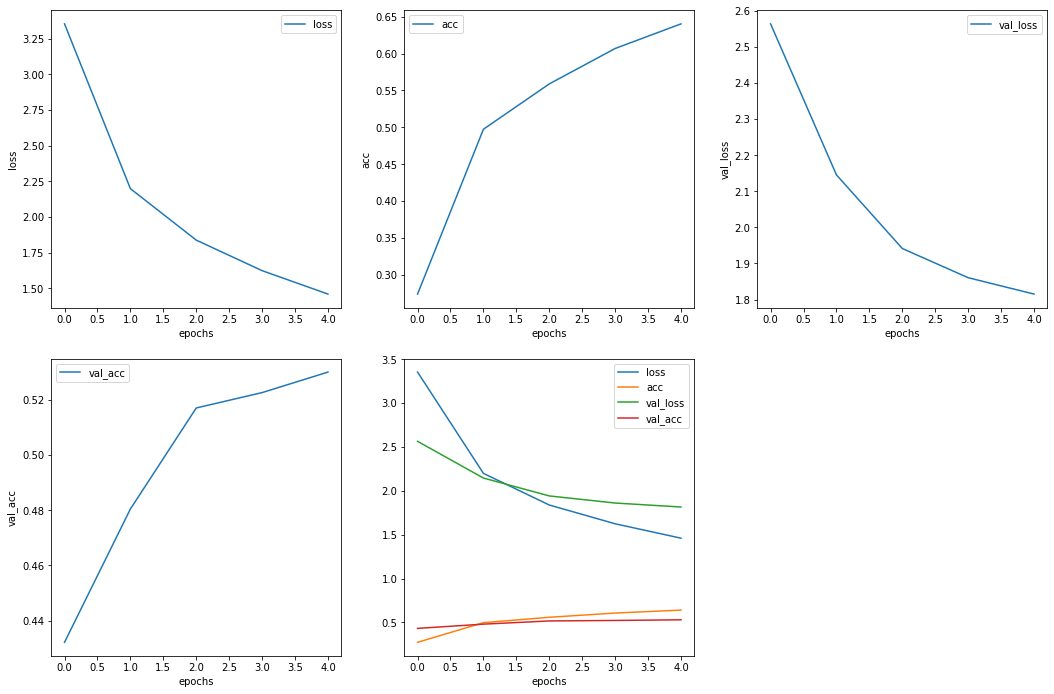

In [16]:
plot_history(history)

In [17]:
score_1 = model.evaluate(test_data) 

790/790 [==============================] - 66s 83ms/step - loss: 1.5938 - acc: 0.5834


In [18]:
train_score_1 = model.evaluate(train_data)

237/237 [==============================] - 21s 84ms/step - loss: 1.2808 - acc: 0.6796


> 🤔 **Question:** What do these curves suggest? Hint: ideally, the two curves should be very similar to each other, if not, there may be some overfitting or underfitting.

## Fine-tuning

Our **feature extraction transfer learning model** is performing well. Why don't we try to **fine-tune** a **few layers in the base model** and see if we gain any improvements?

The good news is, thanks to the `ModelCheckpoint` callback, we've got the saved weights of our already well-performing model so if fine-tuning doesn't add any benefits, we can revert back.

To fine-tune the base model we'll first set its `trainable` attribute to `True`, unfreezing all of the frozen.

Then since we've got a relatively small training dataset, we'll refreeze every layer except for the last 5, making them trainable.

In [19]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
    layer.trainable = False

In [20]:
for layer in base_model.layers[-10:]:
    print(f"{layer.name:-<25} {layer.trainable}")

block7a_se_squeeze------- False
block7a_se_reshape------- False
block7a_se_reduce-------- False
block7a_se_expand-------- False
block7a_se_excite-------- False
block7a_project_conv----- True
block7a_project_bn------- True
top_conv----------------- True
top_bn------------------- True
top_activation----------- True


In [21]:
for layer in model.layers:
    print(f"{layer.name:-<25} {layer.trainable}")

input_layer-------------- True
data_augmentation-------- True
efficientnetb0----------- True
Global_Average_pooling--- True
output_layer------------- True


In [22]:
len(model.trainable_variables)

8

**Because we're fine-tuning, we'll use a 10x lower learning rate to ensure the updates to the previous trained weights aren't too large.**

In [23]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(base_lr/10),
              metrics=["acc"]
              )

In [24]:
fine_tune_epochs = init_epochs + 5

history_2 = model.fit(train_data,
                      epochs=fine_tune_epochs,
                      initial_epoch=history.epoch[-1],
                      validation_data=test_data,
                      validation_steps=int(0.15*len(test_data))
                      )

Epoch 5/10
237/237 [==============================] - 64s 237ms/step - loss: 1.2129 - acc: 0.6822 - val_loss: 1.7769 - val_acc: 0.5315
Epoch 6/10
237/237 [==============================] - 54s 226ms/step - loss: 1.1096 - acc: 0.7055 - val_loss: 1.8014 - val_acc: 0.5297
Epoch 7/10
237/237 [==============================] - 53s 223ms/step - loss: 1.0304 - acc: 0.7299 - val_loss: 1.8039 - val_acc: 0.5336
Epoch 8/10
237/237 [==============================] - 50s 209ms/step - loss: 0.9524 - acc: 0.7439 - val_loss: 1.7853 - val_acc: 0.5315
Epoch 9/10
237/237 [==============================] - 48s 200ms/step - loss: 0.8982 - acc: 0.7575 - val_loss: 1.7722 - val_acc: 0.5381
Epoch 10/10
237/237 [==============================] - 49s 205ms/step - loss: 0.8318 - acc: 0.7776 - val_loss: 1.8038 - val_acc: 0.5373


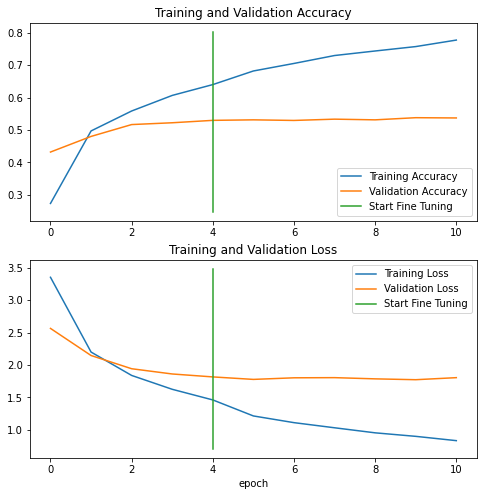

In [25]:
compare_historys(history, history_2)

It seems that after fine-tuning, our model's training metrics improved significantly but validation, not so much. Looks like our model is starting to overfit. 

This is okay though, its very often the case that fine-tuning leads to overfitting when the data a pre-trained model has been trained on is similar to your custom data.

In our case, our pre-trained model, `EfficientNetB0` was trained on [ImageNet](http://www.image-net.org/index) which contains many real life pictures of food just like our food dataset.

If feautre extraction already works well, the improvements you see from fine-tuning may not be as great as if your dataset was significantly different from the data your base model was pre-trained on.

In [26]:
score_2 = model.evaluate(test_data)

790/790 [==============================] - 65s 83ms/step - loss: 1.5087 - acc: 0.5995


In [27]:
train_score_2 = model.evaluate(train_data)

237/237 [==============================] - 20s 82ms/step - loss: 0.8989 - acc: 0.7417


### Comparing

In [28]:
scores = [
    ["model_1", score_1[1], train_score_1[1], train_score_1[1] - score_1[1]],
    ["model_2", score_2[1], train_score_2[1], train_score_2[1] - score_2[1]]
]

pd.DataFrame(scores, columns=["model", "test_score", "train_score", "delta_score"])

,model,test_score,train_score,delta_score
0,model_1,0.583446,0.679604,0.096158
1,model_2,0.599525,0.741650,0.142125


## Making predictions with our trained model


In [29]:
pred_prob = model.predict(test_data)

790/790 [==============================] - 68s 84ms/step


In [30]:
pred_prob[0] # 101 classe

array([1.56173766e-01, 1.08295772e-03, 6.93257526e-02, 6.94251469e-07,
       7.04437298e-06, 1.92013104e-07, 4.16213588e-05, 1.06450871e-05,
       1.36243096e-02, 2.71959580e-04, 2.05397055e-06, 6.68770326e-07,
       3.56897037e-03, 1.02111684e-07, 6.64141495e-03, 7.77228316e-03,
       3.53617761e-05, 4.89633949e-03, 2.46853684e-03, 2.04775006e-05,
       3.58265330e-04, 1.06064390e-05, 8.28589778e-04, 2.18950045e-05,
       3.74570838e-04, 3.53684253e-03, 7.40565686e-03, 7.85453885e-05,
       1.23578623e-01, 4.85905074e-03, 3.16584669e-06, 2.12019077e-03,
       2.01015588e-04, 5.26632675e-07, 9.35316738e-03, 8.97604787e-06,
       3.47452995e-04, 2.14992207e-03, 1.06878899e-01, 3.57798213e-04,
       2.57321168e-04, 1.51613972e-03, 2.05610122e-04, 6.51261580e-05,
       5.00131209e-05, 6.88683285e-05, 4.23890917e-04, 1.50989617e-05,
       6.59951365e-06, 7.47068375e-02, 3.85096035e-04, 2.08474696e-04,
       9.88069475e-02, 6.88106269e-02, 2.01246621e-05, 1.48413675e-02,
      

In [31]:
len(pred_prob)

25250

In [32]:
pred_prob.shape

(25250, 101)

For each image, the prediction is divide in 101 proba, each one for each classe we have

In [33]:
pred_classe = pred_prob.argmax(axis=1)
pred_classe[:10]

array([ 0,  0,  0,  8,  8, 78, 29, 46,  9,  0])

Get the true label 

In [34]:
true_label = []
for image, label in test_data.unbatch():
    true_label.append(label.numpy().argmax())

true_label[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

###Evaluating our models predictions

In [44]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

In [36]:
accuracy_score(true_label, pred_classe) # same as before

0.5995247524752475

In [37]:
f1_score(true_label, pred_classe, average='weighted')

0.6020637514862662

In [47]:
cf_matrix = confusion_matrix(true_label, pred_classe)

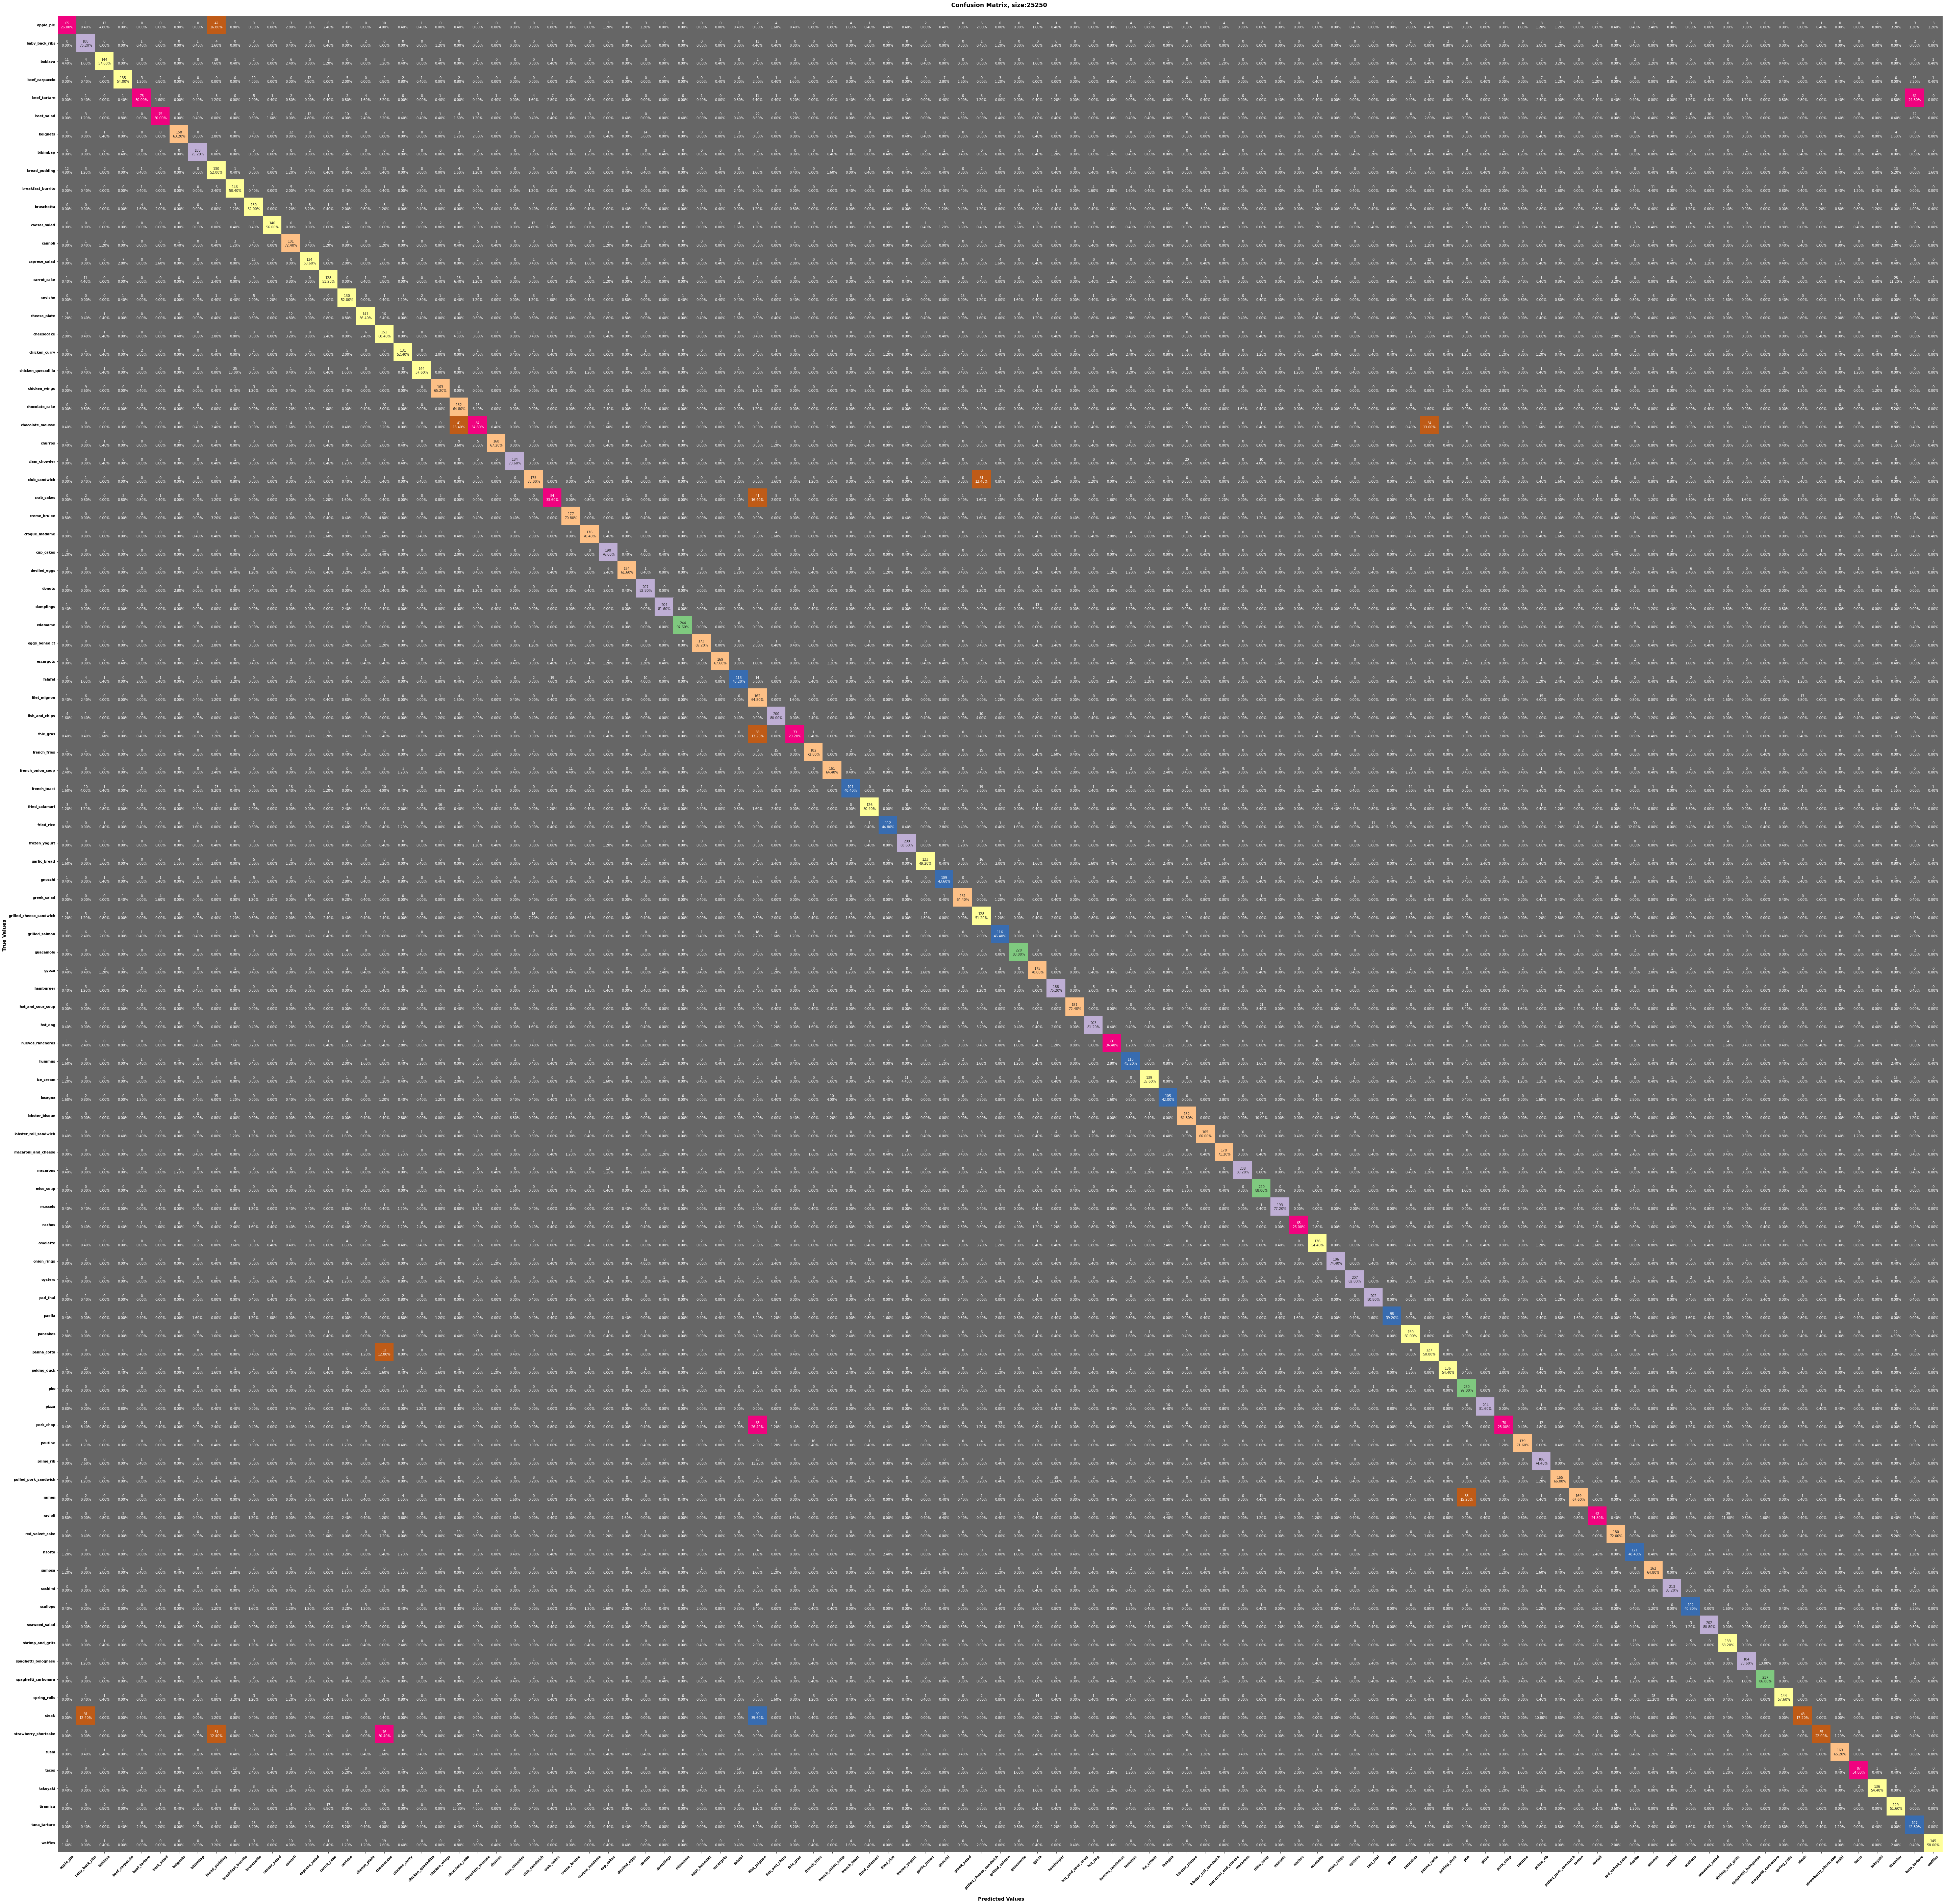

In [46]:
class_names = test_data.class_names

plot_confusion_matrix(cf_matrix, class_names, figsize=(100,100))

In [48]:
print(classification_report(true_label, pred_classe))

              precision    recall  f1-score   support

           0       0.32      0.26      0.29       250
           1       0.48      0.75      0.58       250
           2       0.67      0.58      0.62       250
           3       0.82      0.54      0.65       250
           4       0.62      0.30      0.41       250
           5       0.64      0.30      0.41       250
           6       0.85      0.63      0.72       250
           7       0.84      0.75      0.79       250
           8       0.30      0.52      0.38       250
           9       0.50      0.58      0.54       250
          10       0.43      0.52      0.47       250
          11       0.82      0.56      0.67       250
          12       0.49      0.72      0.58       250
          13       0.61      0.54      0.57       250
          14       0.58      0.51      0.55       250
          15       0.29      0.52      0.37       250
          16       0.64      0.56      0.60       250
          17       0.25    

A reminder:
* **Precision** - Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0).
* **Recall** - Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives.
* **F1 score** - Combines precision and recall into one metric. 1 is best, 0 is worst.

In [49]:
report_dict = classification_report(true_label, pred_classe, output_dict=True)

In [54]:
list(report_dict.keys())[0]

'0'

In [55]:
class_names[0]

'apple_pie'

In [53]:
list(report_dict.values())[0]

{'precision': 0.32338308457711445,
 'recall': 0.26,
 'f1-score': 0.28824833702882485,
 'support': 250}

In [57]:
precision = []
recall = []
f1_score = []
support = []
class_names_report = []

for i, val_dict in report_dict.items():
    if not i.isdigit():
        break
    class_names_report.append(class_names[int(i)])
    precision.append(val_dict["precision"])
    recall.append(val_dict["recall"])
    f1_score.append(val_dict["f1-score"])
    support.append(val_dict["support"])

In [58]:
new_report_dict = {
    "classe_names":class_names_report,
    "precision":precision,
    "recall":recall,
    "f1-score":f1_score,
    "support":support
}

In [61]:
df_report = pd.DataFrame(new_report_dict)
df_report.head()

,classe_names,precision,recall,f1-score,support
0,apple_pie,0.323383,0.260,0.288248,250
1,baby_back_ribs,0.475949,0.752,0.582946,250
2,baklava,0.666667,0.576,0.618026,250
3,beef_carpaccio,0.823171,0.540,0.652174,250
4,beef_tartare,0.625000,0.300,0.405405,250


In [67]:
df_report_f1_sort = df_report.sort_values("f1-score", ascending=False)
df_report_f1_sort.head() # best f1-score

,classe_names,precision,recall,f1-score,support
33,edamame,0.960630,0.976,0.968254,250
63,macarons,0.971963,0.832,0.896552,250
69,oysters,0.892241,0.828,0.858921,250
91,spaghetti_carbonara,0.841085,0.868,0.854331,250
32,dumplings,0.894737,0.816,0.853556,250


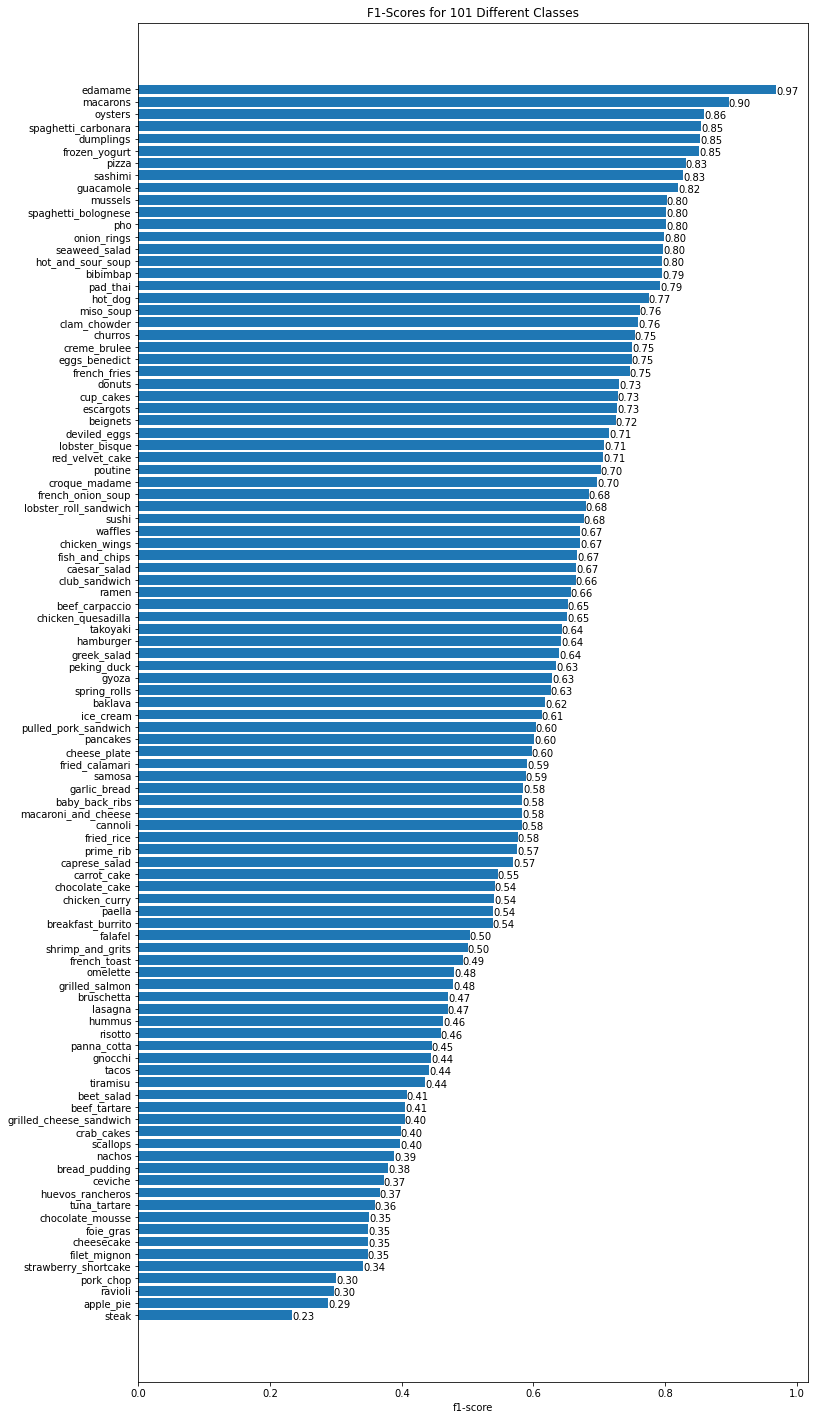

In [75]:
fig, ax = plt.subplots(figsize=(12,25))

barh = ax.barh(df_report_f1_sort["classe_names"], df_report_f1_sort["f1-score"]) # ax.barh(y, width)
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 101 Different Classes")
ax.invert_yaxis()

for bar in barh:
    width = bar.get_width()
    height = bar.get_height()
    y = bar.get_y()
    ax.text(width, y+height, f"{width:.2f}") #ax.text(x, y, s) => x,y : position ; s : text

## Visualizing predictions on test images

Time for the real test. Visualizing predictions on actual images.

As it stands, our model can't just predict on any image of our choice. The image first has to be loaded into a tensor.

So to begin predicting on any given image, we'll create a function to load an image into a tensor.

Specifically, it'll:
* Read in a target image filepath using [`tf.io.read_file()`](https://www.tensorflow.org/api_docs/python/tf/io/read_file).
* Turn the image into a `Tensor` using [`tf.io.decode_image()`](https://www.tensorflow.org/api_docs/python/tf/io/decode_image).
* Resize the image to be the same size as the images our model has been trained on (224 x 224) using [`tf.image.resize()`](https://www.tensorflow.org/api_docs/python/tf/image/resize).
* Scale the image to get all the pixel values between 0 & 1 if necessary.

> NOTE: `io` stand for "inpout output"

In [88]:
def load_image(file_path, im_shape=224, rescale=True):

    raw = tf.io.read_file(file_path)
    im = tf.io.decode_image(raw)
    im = tf.image.resize(im, (im_shape, im_shape))

    if rescale:
        return im/255 # tf.image.convert_image_dtype(im, tf.float32)
    return im

In [118]:
classe_name = random.choice(class_names)
filename = Path(train_dir) / classe_name
file_path = random.choice([id for id in filename.glob("*")])

im = load_image(str(file_path), rescale=False) # don't scale images for EfficientNet predictions
print(im.numpy().shape) # we want [None, 224, 224, 3] for our model
pred_im_prob = model.predict(tf.expand_dims(im, axis=0))# model accepts tensors of shape [None, 224, 224, 3]
pred_im_class = class_names[pred_im_prob.argmax()]

classe_name == pred_im_class, classe_name, pred_im_class

(224, 224, 3)
1/1 [==============================] - 0s 25ms/step


(True, 'fish_and_chips', 'fish_and_chips')

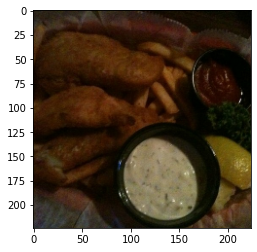

In [119]:
plt.imshow(im/255)